In [1]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

macOS-13.4.1-arm64-arm-64bit


In [2]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;    
print("Tensorflow version " + tf.__version__)

zsh:1: command not found: nvidia-smi
Tensorflow version 2.13.0-rc2


In [3]:
print('we have \n{} NonViolence videos \n{} Violence videos'.format(
              len(os.listdir('/Users/faizahkureshi/Desktop/GAIP Project/Image/NonViolence')), 
              len(os.listdir('/Users/faizahkureshi/Desktop/GAIP Project/Image/Violence'))))

we have 
183 NonViolence videos 
1890 Violence videos


In [4]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

def aug_img(image):

    IMG_SIZE = 128
    ColorChannels = 3
    image = cv2.imread(image)
    resized_image = cv2.resize(image, (128, 128))

In [ ]:
%%time
import cv2
#tqdm is used here to visulaize the progress of dataset creation
from tqdm import tqdm

IMG_SIZE=128
ColorChannels=3

ImgDataDir = '/Users/faizahkureshi/Desktop/GAIP Project/Image'

X_original = []
y_original = []
CLASSES = ["NonViolence", "Violence"]

for category in os.listdir(ImgDataDir):
    category_path = os.path.join(ImgDataDir, category)
    if os.path.isdir(category_path):
        class_num = CLASSES.index(category)
        try:
            img_list = [image for image in os.listdir(category_path)[:350] if image != '.DS_Store']
            for i, image_filename in enumerate(tqdm(img_list)):
                image_path = os.path.join(category_path, image_filename)
                image = cv2.imread(image_path)
                rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                X_original.append(resized)
                y_original.append(class_num)
        except OSError as e:
            print(f"Error processing directory: {category_path}. Skipping...")
            continue

In [6]:
len(y_original)

532

In [7]:
import numpy as np
IMG_SIZE=128
X_original = np.array(X_original).reshape(532,IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

532

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

In [9]:
pip install --upgrade certifi


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import certifi
import os
os.environ['SSL_CERT_DIR'] = certifi.where()


In [11]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [14]:
#freezing weights for resnet 50 model
for layer in base_model.layers:
    layer.trainable = False


In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [17]:
model.fit(X_train_nn, y_train, validation_data=(X_test_nn, y_test), epochs=50, batch_size=32)


Epoch 1/50
12/12 [==============================] - 9s 686ms/step - loss: 0.6574 - accuracy: 0.6425 - val_loss: 0.6180 - val_accuracy: 0.6562
Epoch 2/50
12/12 [==============================] - 7s 608ms/step - loss: 0.6300 - accuracy: 0.6667 - val_loss: 0.6036 - val_accuracy: 0.6562
Epoch 3/50
12/12 [==============================] - 7s 598ms/step - loss: 0.5838 - accuracy: 0.6586 - val_loss: 0.5787 - val_accuracy: 0.6562
Epoch 4/50
12/12 [==============================] - 8s 654ms/step - loss: 0.5671 - accuracy: 0.6747 - val_loss: 0.5660 - val_accuracy: 0.6562
Epoch 5/50
12/12 [==============================] - 8s 641ms/step - loss: 0.5542 - accuracy: 0.6909 - val_loss: 0.5536 - val_accuracy: 0.6812
Epoch 6/50
12/12 [==============================] - 7s 610ms/step - loss: 0.5402 - accuracy: 0.6882 - val_loss: 0.5471 - val_accuracy: 0.7812
Epoch 7/50
12/12 [==============================] - 7s 629ms/step - loss: 0.5308 - accuracy: 0.7796 - val_loss: 0.5384 - val_accuracy: 0.7625
Epoch 

In [18]:
loss, accuracy = model.evaluate(X_test_nn, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


5/5 [==============================] - 2s 423ms/step - loss: 0.3963 - accuracy: 0.8500
Test Loss: 0.39630043506622314
Test Accuracy: 0.8500000238418579


In [21]:
predictions = model.predict(X_test_nn)

5/5 [==============================] - 2s 413ms/step


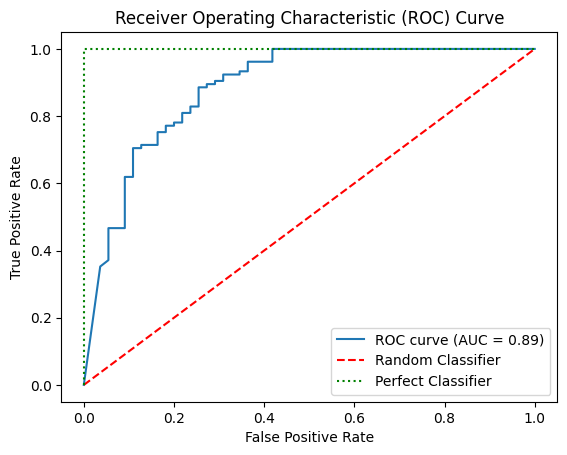

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Example predicted probabilities and true labels
predicted_probabilities = predictions
true_labels =y_test

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)

# Calculate the Area Under the Curve (AUC)
auc = roc_auc_score(true_labels, predicted_probabilities)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='g', label='Perfect Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [20]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
5/5 [==============================] - 3s 402ms/step


In [25]:
from scikitplot.metrics import plot_roc_curve

In [26]:
import seaborn as sns
from sklearn import metrics
from scikitplot.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonViolence", "Violence"]))

ImportError: cannot import name 'plot_roc_curve' from 'sklearn.metrics' (/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/__init__.py)